<img src="https://raw.githubusercontent.com/dask/dask/main/docs/source/images/dask_horizontal.svg"
     width="60%"
     alt="Dask logo\" />

# Arrays

Dask array provides a parallel, larger-than-memory implementation of NumPy. 

It will look and feel a lot like NumPy, but does not suffer from the same scalability limitations.


<img src="https://docs.dask.org/en/latest/_images/dask-array.svg" width="50%" align="center" alt="Dask array">


*  **Parallel**: Uses all of the cores on your computer
*  **Larger-than-memory**:  Lets you work on datasets that are larger than your available memory by breaking up your array into many small pieces, operating on those pieces in an order that minimizes the memory footprint of your computation, and effectively streaming data from disk.
*  **Blocked Algorithms**:  Perform large computations by performing many smaller computations

In this notebook, we'll build some understanding by implementing some blocked algorithms from scratch. We'll then use Dask Array to analyze large datasets, in parallel, using a familiar NumPy-like API.


## Blocked Algorithms

A *blocked algorithm* executes on a large dataset by breaking it up into many small blocks.

For example, consider taking the sum of a billion numbers.  We might instead break up the array into 1,000 chunks, each of size 1,000,000, take the sum of each chunk, and then take the sum of the intermediate sums.

We achieve the intended result (one sum on one billion numbers) by performing many smaller results (one thousand sums on one million numbers each, followed by another sum of a thousand numbers.)

We do exactly this with Python and NumPy in the following example:

### Create data

In [5]:
%run ../prep-alt.py -d random

In [6]:
# Load data with h5py
# this creates a pointer to the data, but does not actually load
import os

import h5py

f = h5py.File(os.path.join("../", "data", "random.hdf5"), mode="r")
dset = f["/x"]

In [7]:
dset

<HDF5 dataset "x": shape (1000000000,), type "<f4">

### Example: Compute sum using blocked algorithm

Before using dask, let's consider the concept of blocked algorithms. We can compute the sum of a large number of elements by loading them chunk-by-chunk, and keeping a running total.

Here we compute the sum of this large array on disk by 

1.  Computing the sum of each 1,000,000 sized chunk of the array
2.  Computing the sum of the 1,000 intermediate sums

Note that this is a sequential process in the notebook kernel, both the loading and summing.

In [8]:
%%time
# Compute sum of large array, one million numbers at a time
sums = []
for i in range(0, 1_000_000_000, 1_000_000):
    chunk = dset[i : i + 1_000_000]  # pull out numpy array
    sums.append(chunk.sum())

total = sum(sums)
print(total)

1000037133.3125
CPU times: user 205 ms, sys: 560 ms, total: 765 ms
Wall time: 764 ms


`dask.array` contains these algorithms
--------------------------------------------

Dask.array is a NumPy-like library that does these kinds of tricks to operate on large datasets that don't fit into memory.  It extends beyond the linear problems discussed above to full N-Dimensional algorithms and a decent subset of the NumPy interface.

**Create `dask.array` object**

You can create a `dask.array` `Array` object with the `da.from_array` function.  This function accepts

1.  `data`: Any object that supports NumPy slicing, like `dset`
2.  `chunks`: A chunk size to tell us how to block up our array, like `(1_000_000,)`

In [9]:
import dask.array as da

x = da.from_array(dset, chunks=(1_000_000,))
x

dask.array<array, shape=(1000000000,), dtype=float32, chunksize=(1000000,), chunktype=numpy.ndarray>

**Manipulate `dask.array` object as you would a numpy array**

Now that we have an `Array` we perform standard numpy-style computations like arithmetic, mathematics, slicing, reductions, etc..

The interface is familiar, but the actual work is different. `dask_array.sum()` builds an expression of the computation. It does not do the computation yet. `numpy_array.sum()` computes the sum immediately.

In [11]:
result = x.sum()
result

dask.array<sum-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>

**Compute result**

Dask.array objects are lazily evaluated.  Operations like `.sum` build up a graph of blocked tasks to execute.  

We ask for the final result with a call to `.compute()`.  This triggers the actual computation.

In [12]:
result.compute()

1000037100.0

### Example:  Compute the mean

This is a small change to the example above.

In [13]:
x.mean().compute()

1.0000371

Does this match your result from before?

### Example:  Compute the standard deviation

Again, this follows regular NumPy syntax, except for the added `.compute()`

In [14]:
x.std().compute()

1.0000457

## Exercise:  Meteorological data

There is 2GB of weather data in HDF5 files in `../data/weather-big/*.hdf5`.  We'll use the `h5py` library to interact with this data and `dask.array` to compute on it.

Our goal is to visualize the average temperature on the surface of the Earth for this month.  This will require a mean over all of this data.  We'll do this in the following steps

1.  Create `h5py.Dataset` objects for each of the days of data on disk (`dsets`)
2.  Wrap these with `da.from_array` calls 
3.  Stack these datasets along time with a call to `da.stack`
4.  Compute the mean along the newly stacked time axis with the `.mean()` method
5.  Visualize the result with `matplotlib.pyplot.imshow`

In [15]:
%run ../prep-alt.py -d weather

In [16]:
import os
from glob import glob

import h5py

filenames = sorted(glob(os.path.join("../data", "weather-big", "*.hdf5")))
dsets = [h5py.File(filename, mode="r")["/t2m"] for filename in filenames]
dsets[0]

<HDF5 dataset "t2m": shape (5760, 11520), type "<f8">

In [17]:
type(dset)

h5py._hl.dataset.Dataset

### Exercise 1: Integrate with `dask.array`

Make a list of `dask.array` objects out of your list of `h5py.Dataset` objects using the `da.from_array` function with a chunk size of `(500, 500)`.

Uncomment and run the cell below to see the solution.

In [19]:
# %load solutions/array-ex-1.py
arrays = [da.from_array(dset, chunks=(500, 500)) for dset in dsets]
arrays

[dask.array<array, shape=(5760, 11520), dtype=float64, chunksize=(500, 500), chunktype=numpy.ndarray>,
 dask.array<array, shape=(5760, 11520), dtype=float64, chunksize=(500, 500), chunktype=numpy.ndarray>,
 dask.array<array, shape=(5760, 11520), dtype=float64, chunksize=(500, 500), chunktype=numpy.ndarray>,
 dask.array<array, shape=(5760, 11520), dtype=float64, chunksize=(500, 500), chunktype=numpy.ndarray>,
 dask.array<array, shape=(5760, 11520), dtype=float64, chunksize=(500, 500), chunktype=numpy.ndarray>,
 dask.array<array, shape=(5760, 11520), dtype=float64, chunksize=(500, 500), chunktype=numpy.ndarray>,
 dask.array<array, shape=(5760, 11520), dtype=float64, chunksize=(500, 500), chunktype=numpy.ndarray>,
 dask.array<array, shape=(5760, 11520), dtype=float64, chunksize=(500, 500), chunktype=numpy.ndarray>,
 dask.array<array, shape=(5760, 11520), dtype=float64, chunksize=(500, 500), chunktype=numpy.ndarray>,
 dask.array<array, shape=(5760, 11520), dtype=float64, chunksize=(500, 50

### Exercise 2: Stack list of `dask.array` objects into a single `dask.array` object with `da.stack`

Stack these along the first axis so that the shape of the resulting array is `(31, 5760, 11520)`.

In [21]:
# %load solutions/array-ex-2.py
x = da.stack(arrays, axis=0)
x

,Array,Chunk
Bytes,15.33 GiB,1.91 MiB
Shape,"(31, 5760, 11520)","(1, 500, 500)"
Count,17887 Tasks,8928 Chunks
Type,float64,numpy.ndarray


### Exercise 3: Plot the mean of this array along the time (`0th`) axis

Complete the following:

```python
result = ...
fig = plt.figure(figsize=(16, 8))
plt.imshow(result, cmap='RdBu_r')
```

In [22]:
import matplotlib.pyplot as plt

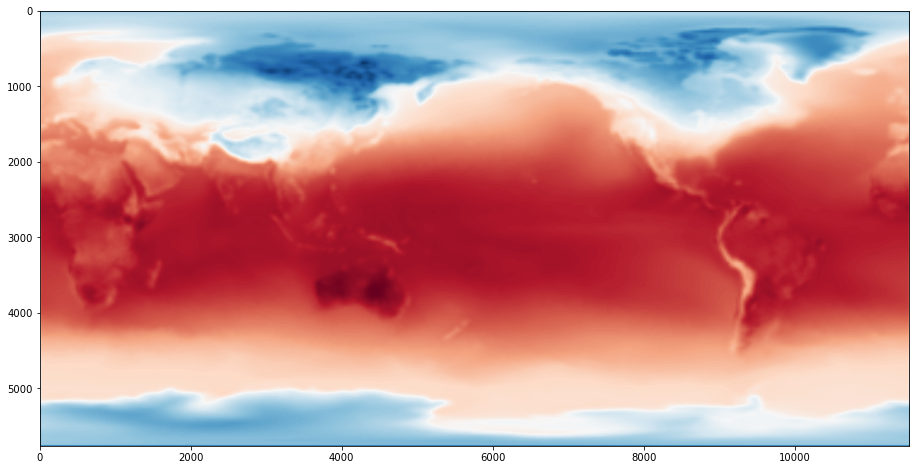

In [24]:
# %load solutions/array-ex-3.py
result = x.mean(axis=0)
fig = plt.figure(figsize=(16, 8))
plt.imshow(result, cmap="RdBu_r");

Performance comparison
---------------------------

The following experiment was performed on a personal laptop with 16GB of RAM and 8 CPU cores.  Your performance may vary. If you attempt the NumPy version then please ensure that you have more than 4GB of main memory.

**NumPy: ~7s, Needs gigabytes of memory**

```python
import numpy as np

%%time 
x = np.random.normal(10, 0.1, size=(20000, 20000)) 
y = x.mean(axis=0)[::100] 
y 

CPU times: user 6.73 s, sys: 331 ms, total: 7.16 s
Wall time: 7.11 s
```

**Dask Array: ~1.5s, Needs megabytes of memory**

```python
import dask.array as da

%%time
x = da.random.normal(10, 0.1, size=(20000, 20000), chunks=(1000, 1000))
y = x.mean(axis=0)[::100] 
y.compute() 

CPU times: user 635 ms, sys: 119 ms, total: 754 ms
Wall time: 1.69 s
```

**Discussion**

Dask finished faster, but used more total CPU time because Dask was able to transparently parallelize the computation because of the chunk size.